In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin_cg
import scipy.io as si
plt.rcParams['axes.formatter.limits'] = [-3,3]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1 Regularized Linear Regression

## 1.1 Visualizing the data

In [2]:
a = si.loadmat('ex5_octave/ex5data1.mat')
X = a['X']
y = a['y'].flatten()
Xval = a['Xval']
yval = a['yval'].flatten()
Xtest = a['Xtest']
ytest = a['ytest'].flatten()

# number of training examples
m = X.shape[0]

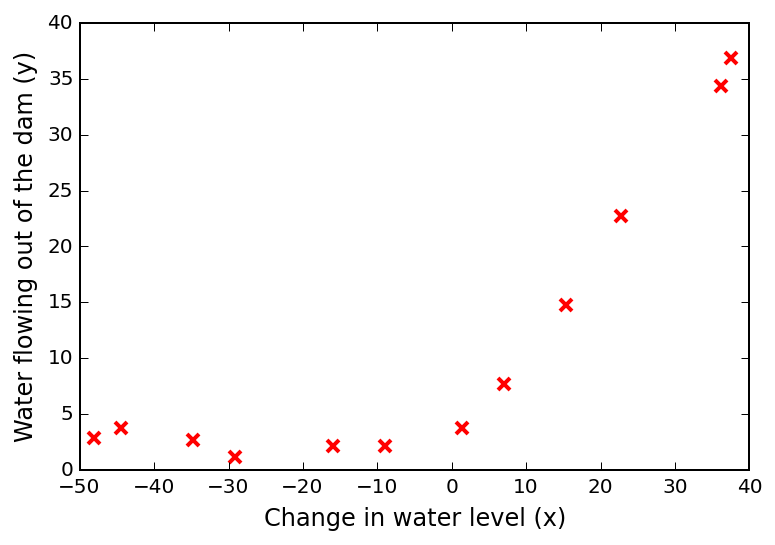

In [3]:
# plot the training data
plt.plot(X, y, 'rx', mew=2)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

## 1.2 Regularized linear regression cost function

In [4]:
def linearRegCostFunction(X, y, theta, lam):
    
    m = len(y)
    
    lamarray = np.ones(len(theta)) * lam
    lamarray[0] = 0
    
    J = 0
    grad = np.zeros(theta.size)
    
    dt = np.dot(X, theta) - y
    
    J =  1 / 2 / m * (np.dot(dt, dt) + np.dot(lamarray, theta**2))
    
    grad = np.dot(X.T, (np.dot(X,theta) - y)) / m
    grad += lamarray * theta / m
    
    return J, grad

In [5]:
# test cost function
theta = np.ones(2)
J, grad = linearRegCostFunction(np.hstack((np.ones((m, 1)), X)), y, theta, 1)
print J, grad

303.99319222 [ -15.30301567  598.25074417]


## 1.4 Fitting Linear Regression

In [6]:
def trainLinearReg(X, y, lam):
    
    # initialize Theta
    initial_theta = np.zeros(X.shape[1])
    
    # create cost and grad functions
    cost = lambda x: linearRegCostFunction(X, y, x, lam)[0]
    grad = lambda x: linearRegCostFunction(X, y, x, lam)[1]
    
    # minimize using fmincg
    theta = fmin_cg(cost, initial_theta, fprime=grad, 
                    maxiter=200, disp=False)
    
    return theta

In [7]:
# run on training set
lam = 0
Xnew = np.hstack((np.ones((m, 1)), X))
theta = trainLinearReg(Xnew, y, lam)

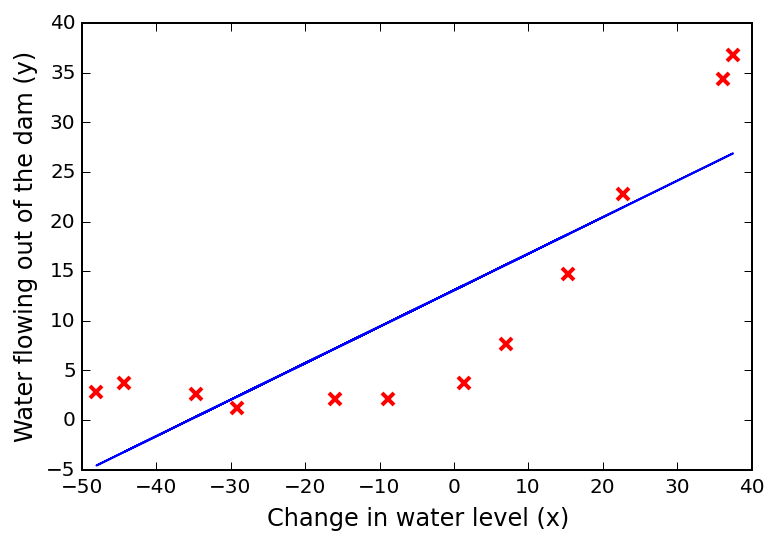

In [8]:
# plot results
plt.plot(X, y, 'rx', mew=2)
plt.plot(X, np.dot(Xnew,theta))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

# 2 Bias-variance

## 2.2 Learning curves

In [9]:
def learningCurve(X, y, Xval, yval, lam):
    
    m = X.shape[0]
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)    
    
    # compute training error over subset of training set
    for ct, ii in enumerate(range(1,m+1)):
                
        # compute theta for traning subset
        theta = trainLinearReg(X[:ii,:], y[:ii], lam)
        
        # training/validation error
        error_train[ct] = linearRegCostFunction(X[:ii,:], y[:ii], theta, 0)[0]
        error_val[ct] = linearRegCostFunction(Xval, yval, theta, 0)[0]
        
    return error_train, error_val
        

In [10]:
lam = 0
error_train, error_val = learningCurve(
    np.hstack((np.ones((m, 1)), X)), y,
    np.hstack((np.ones((Xval.shape[0], 1)), Xval)), 
    yval, lam)

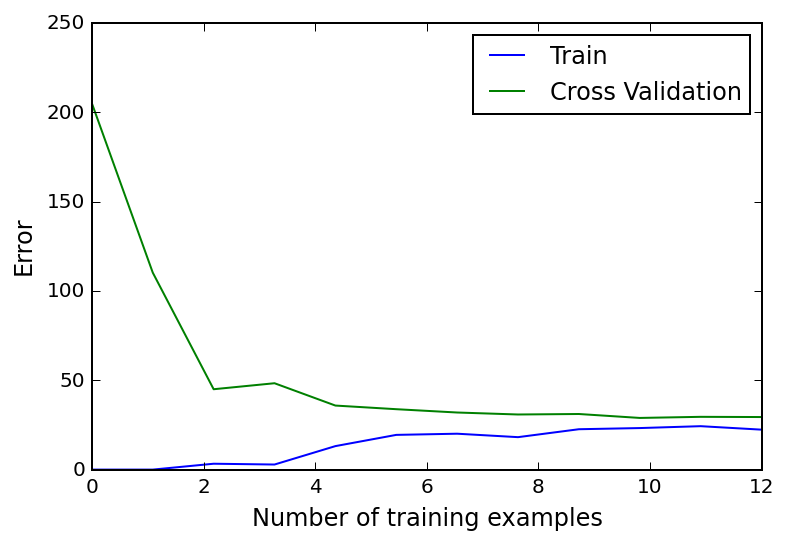

In [11]:
plt.plot(np.linspace(0, m, m), error_train, label='Train')
plt.plot(np.linspace(0, m, m), error_val, label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()

# 3 Polynomial regression

In [12]:
def polyFeatures(X, p):
    
    m = X.shape[0]
    Xpoly = np.zeros((m, p))
    Xpoly[:,0] = X[:,0]
    
    for ii in range(1,p):
        Xpoly[:,ii] = X[:,0]**(ii+1)
        
    return Xpoly

def featureNormalize(X):
    
    # compute mean and standard deviation
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma  

def plotFit(min_x, max_x, mu, sigma, theta, p):
    
    x = np.arange(min_x-15, max_x+25, 0.05)
    x = np.reshape(x, (len(x), 1))
    
    # Map X and normalize
    X_poly = polyFeatures(x, p)
    X_poly = (X_poly - mu) / sigma
    X_poly = np.hstack((np.ones((X_poly.shape[0], 1)), 
                         X_poly))
    
    # plot
    plt.plot(x, np.dot(X_poly,theta))

In [13]:
p = 8

# Map X onto Polynomical Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.hstack((np.ones((m, 1)), X_poly))

# Map X_poly_test and normalize
X_poly_test = polyFeatures(Xtest, p)
X_poly_test = (X_poly_test - mu) / sigma
X_poly_test = np.hstack((np.ones((X_poly_test.shape[0], 1)), 
                         X_poly_test))

# Map X_poly_val and normalize
X_poly_val = polyFeatures(Xval, p)
X_poly_val = (X_poly_val - mu) / sigma
X_poly_val = np.hstack((np.ones((X_poly_val.shape[0], 1)), 
                         X_poly_val))

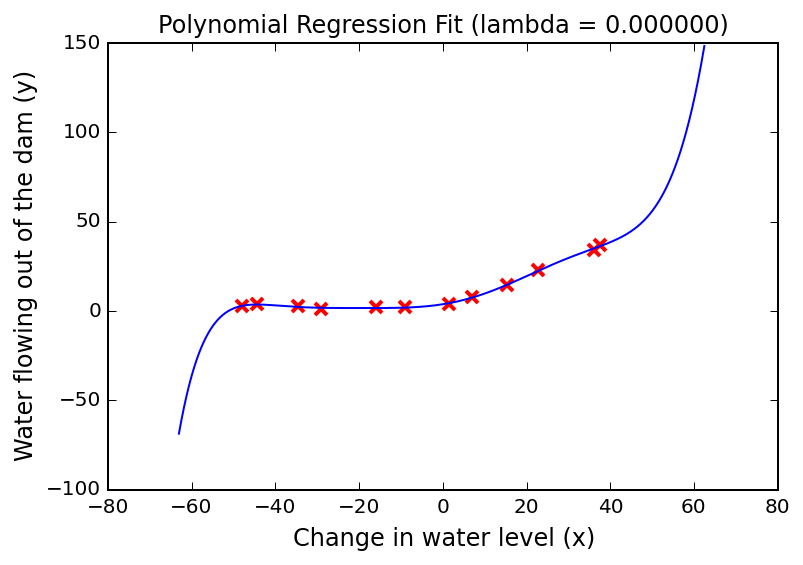

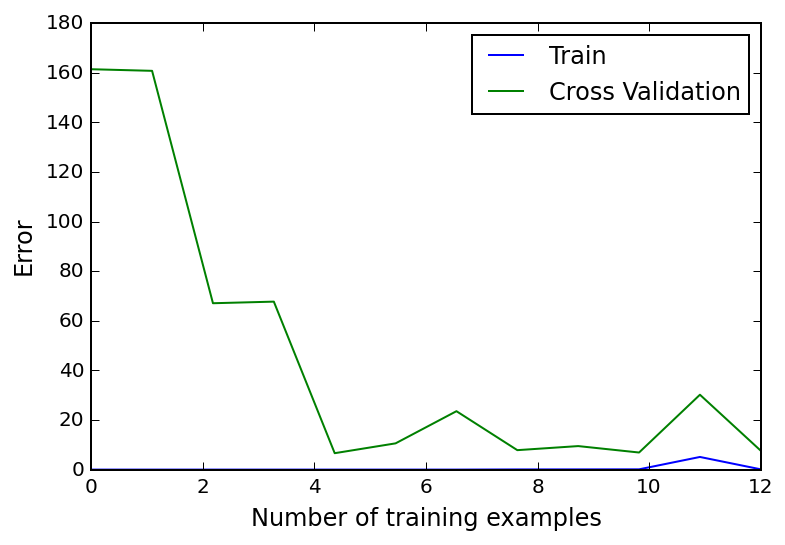

In [14]:
# train model on training set
lam = 0
theta = trainLinearReg(X_poly, y, lam)

# learning curve
error_train, error_val = learningCurve(
    X_poly, y, X_poly_val, yval, lam)

# plot fit
plt.figure()
plt.plot(X, y, 'rx', mew=2)
plotFit(np.min(X), np.max(X), mu, sigma, theta, p)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit (lambda = %f)'%lam)

# plot learning curve
plt.figure()
plt.plot(np.linspace(0, m, m), error_train, label='Train')
plt.plot(np.linspace(0, m, m), error_val, label='Cross Validation')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()

## 3.2 Adjusting the regularization parameter

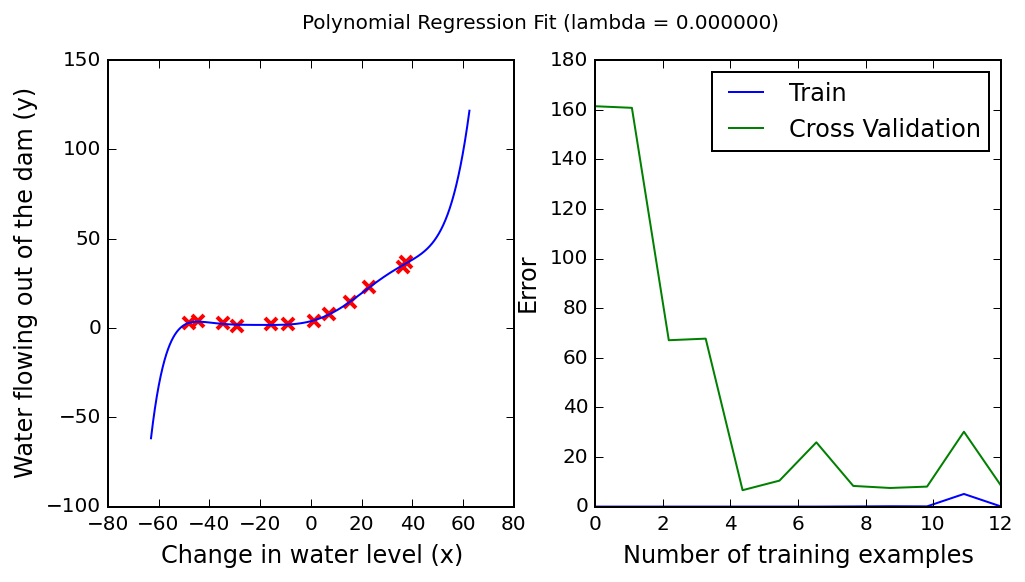

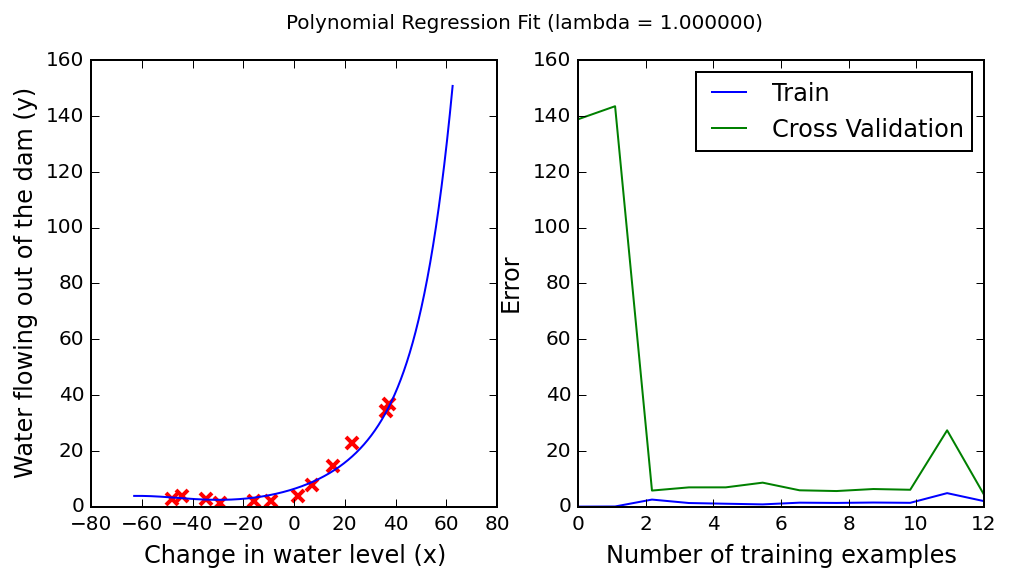

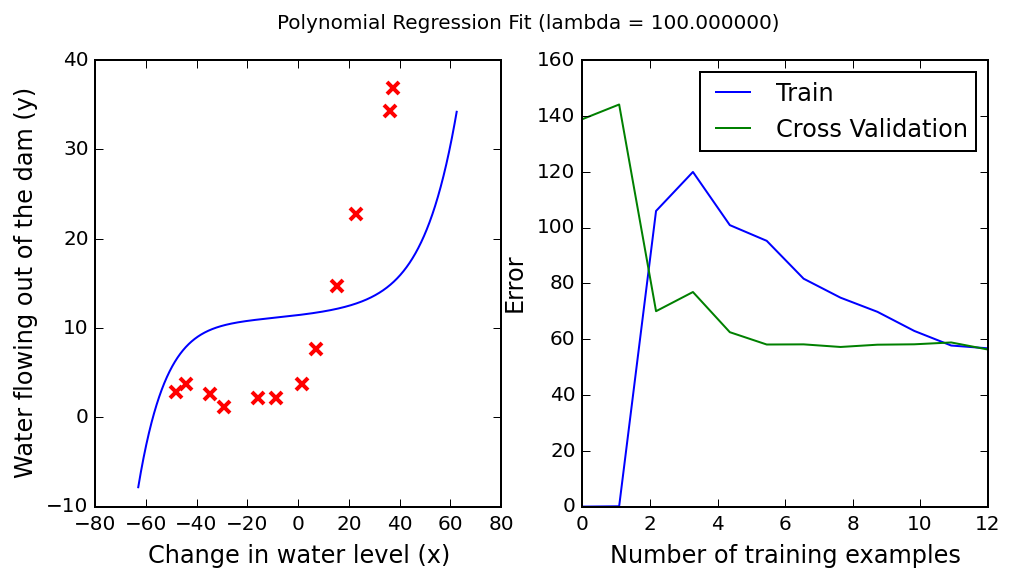

In [17]:
# train model on training set
lams = [0, 1, 100]

for lam in lams:
    
    theta = trainLinearReg(X_poly, y, lam)

    # learning curve
    error_train, error_val = learningCurve(
        X_poly, y, X_poly_val, yval, lam)
    
    fig = plt.figure(figsize=(8,4))

    # plot fit
    ax = plt.subplot(121)
    ax.plot(X, y, 'rx', mew=2)
    plotFit(np.min(X), np.max(X), mu, sigma, theta, p)
    ax.set_xlabel('Change in water level (x)')
    ax.set_ylabel('Water flowing out of the dam (y)')

    # plot learning curve
    ax = plt.subplot(122)
    ax.plot(np.linspace(0, m, m), error_train, label='Train')
    ax.plot(np.linspace(0, m, m), error_val, label='Cross Validation')
    ax.set_xlabel('Number of training examples')
    ax.set_ylabel('Error')
    ax.legend()
    
    plt.suptitle('Polynomial Regression Fit (lambda = %f)'%lam)

## 3.3 Selecting $\lambda$ using cross validation

In [29]:
def validationCurve(X, y, Xval, yval):
    
    lams = [0, 0.001, 0.003, 0.01, 0.03, 0.1,
            0.3, 1, 3, 10]
    
    error_train = np.zeros(len(lams))
    error_val = np.zeros(len(lams))
    
    for ct, lam in enumerate(lams):
        
        # compute theta for traning set
        theta = trainLinearReg(X, y, lam)
        
        # training/validation error
        error_train[ct] = linearRegCostFunction(X, y, theta, 0)[0]
        error_val[ct] = linearRegCostFunction(Xval, yval, theta, 0)[0]
        
    
    return np.array(lams), error_train, error_val

In [30]:
lams, error_train, error_val = validationCurve(
    X_poly, y, X_poly_val, yval)

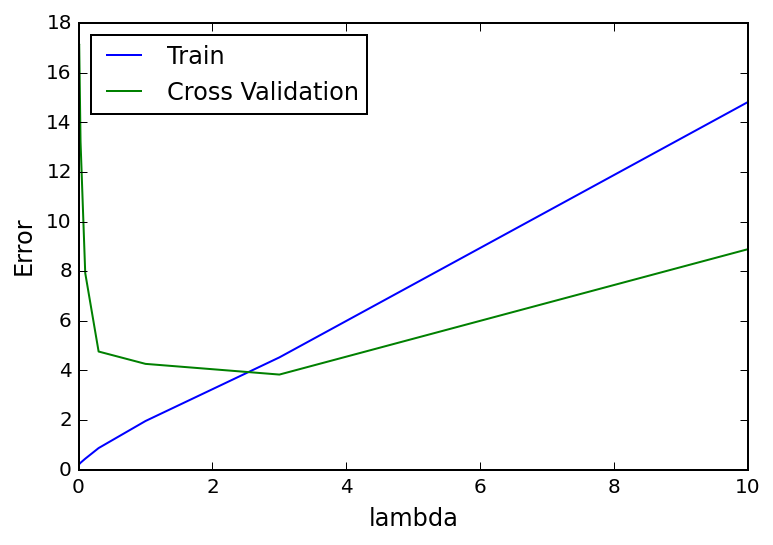

In [31]:
plt.plot(lams, error_train, label='Train')
plt.plot(lams, error_val, label='Cross Validation')
plt.xlabel('lambda')
plt.ylabel('Error')
plt.legend(loc='best')

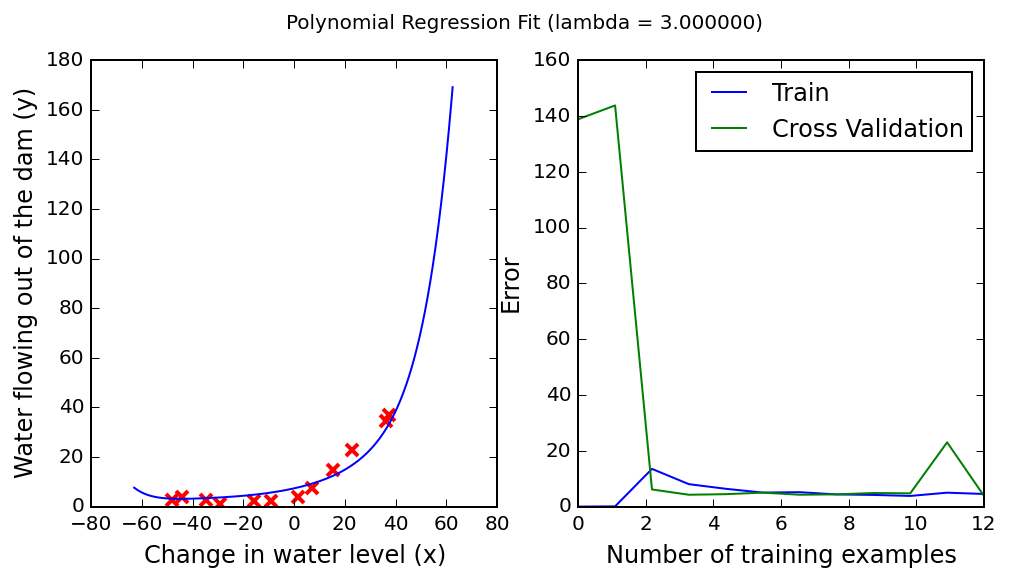

In [34]:
# train model on training set
lam = 3
theta = trainLinearReg(X_poly, y, lam)

# learning curve
error_train, error_val = learningCurve(
    X_poly, y, X_poly_val, yval, lam)

fig = plt.figure(figsize=(8,4))

# plot fit
ax = plt.subplot(121)
ax.plot(X, y, 'rx', mew=2)
plotFit(np.min(X), np.max(X), mu, sigma, theta, p)
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')

# plot learning curve
ax = plt.subplot(122)
ax.plot(np.linspace(0, m, m), error_train, label='Train')
ax.plot(np.linspace(0, m, m), error_val, label='Cross Validation')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Error')
ax.legend()

plt.suptitle('Polynomial Regression Fit (lambda = %f)'%lam)

## 3.4 Computing test set error

In [36]:
lam = 3
print linearRegCostFunction(X_poly_test, ytest, theta, 0)[0]

3.57202232105


## 3.5 Randomly selected learning curves

In [47]:
def learningCurveRandom(X, y, Xval, yval, lam):
    
    m = X.shape[0]
    nreal = 50
    
    error_train = np.zeros(m)
    error_val = np.zeros(m)    
    
    # compute training error over subset of training set
    for ct, ii in enumerate(range(1,m+1)):
        train_tmp = np.zeros(nreal)
        val_tmp = np.zeros(nreal)
        for jj in range(nreal):
            
            ind = np.random.choice(np.arange(0, m), size=ii, replace=False)
                
            # compute theta for traning subset
            theta = trainLinearReg(X[ind,:], y[ind], lam)

            # training/validation error
            train_tmp[jj] = linearRegCostFunction(X[ind,:], y[ind], theta, 0)[0]
            val_tmp[jj] = linearRegCostFunction(Xval, yval, theta, 0)[0]
        
        error_train[ct] = train_tmp.mean()
        error_val[ct] = val_tmp.mean()
        
    return error_train, error_val

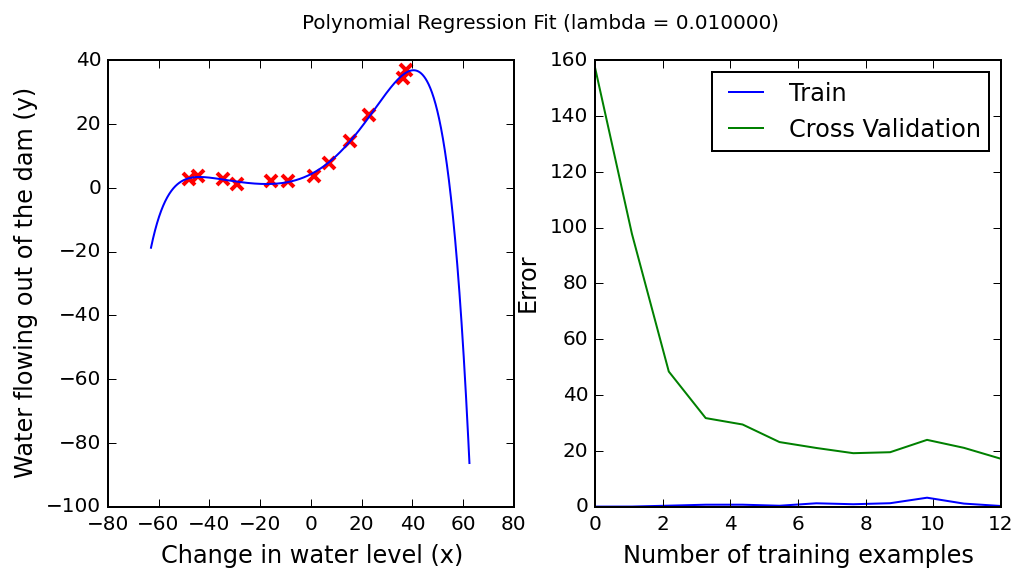

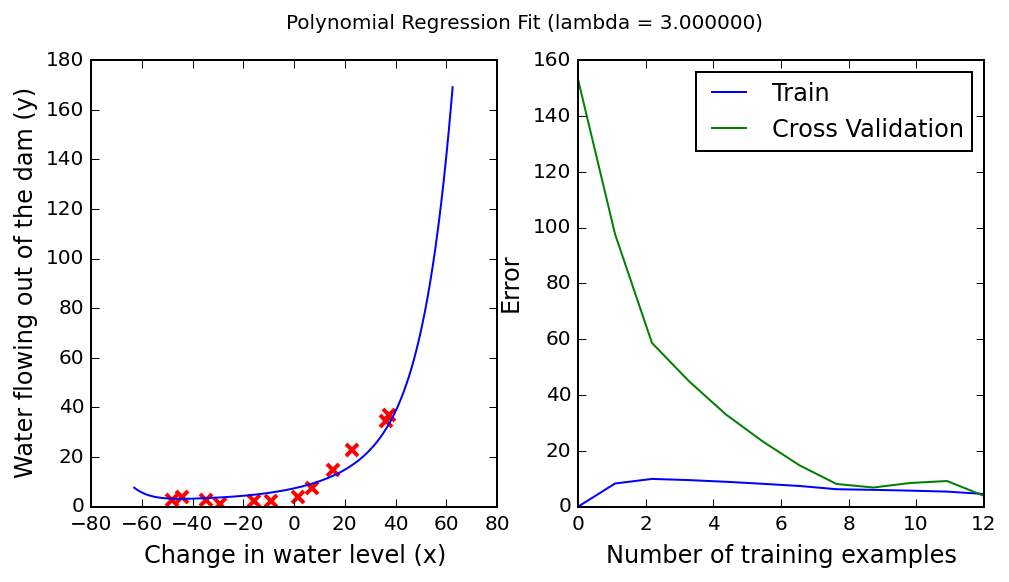

In [51]:
# train model on training set
lams = [0.01, 3]

for lam in lams:
    
    theta = trainLinearReg(X_poly, y, lam)

    # learning curve
    error_train, error_val = learningCurveRandom(
        X_poly, y, X_poly_val, yval, lam)
    
    fig = plt.figure(figsize=(8,4))

    # plot fit
    ax = plt.subplot(121)
    ax.plot(X, y, 'rx', mew=2)
    plotFit(np.min(X), np.max(X), mu, sigma, theta, p)
    ax.set_xlabel('Change in water level (x)')
    ax.set_ylabel('Water flowing out of the dam (y)')

    # plot learning curve
    ax = plt.subplot(122)
    ax.plot(np.linspace(0, m, m), error_train, label='Train')
    ax.plot(np.linspace(0, m, m), error_val, label='Cross Validation')
    ax.set_xlabel('Number of training examples')
    ax.set_ylabel('Error')
    ax.legend()
    
    plt.suptitle('Polynomial Regression Fit (lambda = %f)'%lam)